<a href="https://colab.research.google.com/github/JohnTichenor/Locating-Bacterial-Flagellar-Motors/blob/main/Data_Vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

In [ ]:
!pip install ipyvolume

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 271.7/271.7 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.6 MB/s eta 0:00:00


## Mount Drive

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ipywidgets as widgets
import ipyvolume as ipv
import math
import pandas as pd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Visualize the Training Data

Number of JPG slices found: 500
Volume shape: (500, 1912, 1847)


interactive(children=(IntSlider(value=0, description='idx', max=499), Output()), _dom_classes=('widget-interac…

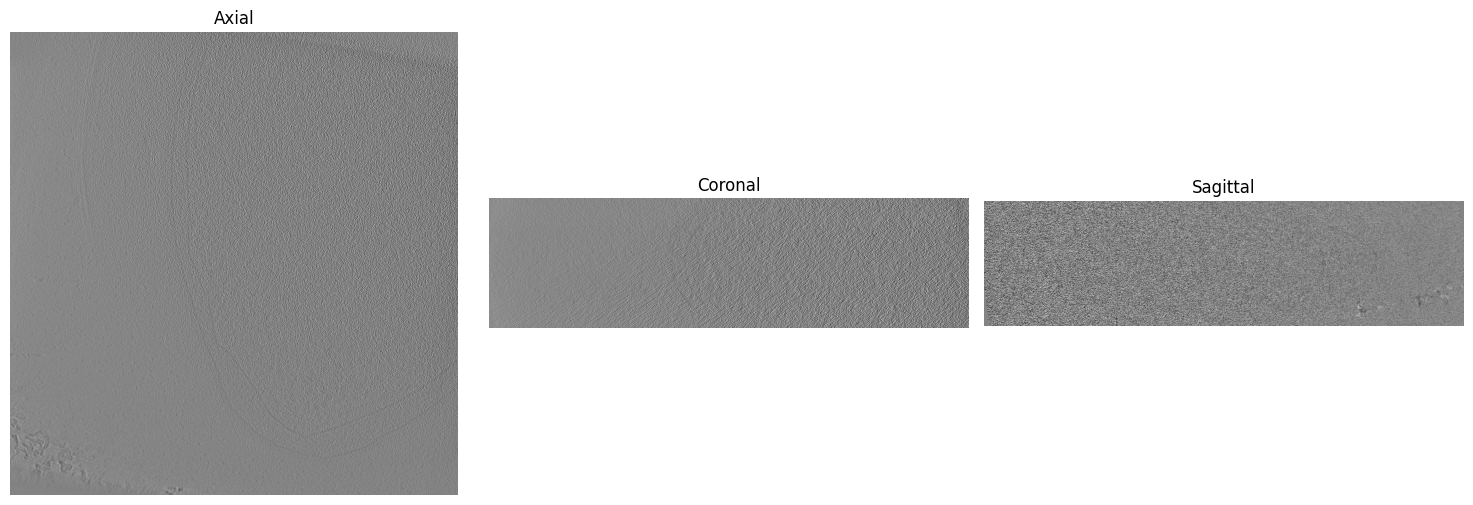

In [ ]:
def visualize_tomographic_volume(folder_path):
    """
    Load JPG slices from the given folder path, stack into a 3D volume,
    and visualize with interactive and orthogonal slice views.

    Parameters:
        folder_path (str): Path to the folder containing .jpg slices
    """
    # Step 1: Get and sort all .jpg image paths
    image_paths = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith('.jpg')
    ])

    print(f"Number of JPG slices found: {len(image_paths)}")

    # Step 2: Stack images into a 3D volume (depth, height, width)
    volume = np.stack([mpimg.imread(p) for p in image_paths])
    print("Volume shape:", volume.shape)

    # Step 3: Interactive scroll-through viewer
    def view_slice(idx):
        plt.imshow(volume[idx], cmap='gray')
        plt.title(f"Slice {idx}")
        plt.axis('off')
        plt.show()

    widgets.interact(view_slice, idx=widgets.IntSlider(min=0, max=volume.shape[0]-1, step=1))

    # Step 4: Display middle slice in each plane
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(volume[volume.shape[0]//2], cmap='gray')       # Axial
    plt.title('Axial'); plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(volume[:, volume.shape[1]//2, :], cmap='gray') # Coronal
    plt.title('Coronal'); plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(volume[:, :, volume.shape[2]//2], cmap='gray') # Sagittal
    plt.title('Sagittal'); plt.axis('off')

    plt.tight_layout()
    plt.show()


folder_path = '/content/drive/MyDrive/BacterialFlagellarMotorsData/test/tomo_003acc'
visualize_tomographic_volume(folder_path)


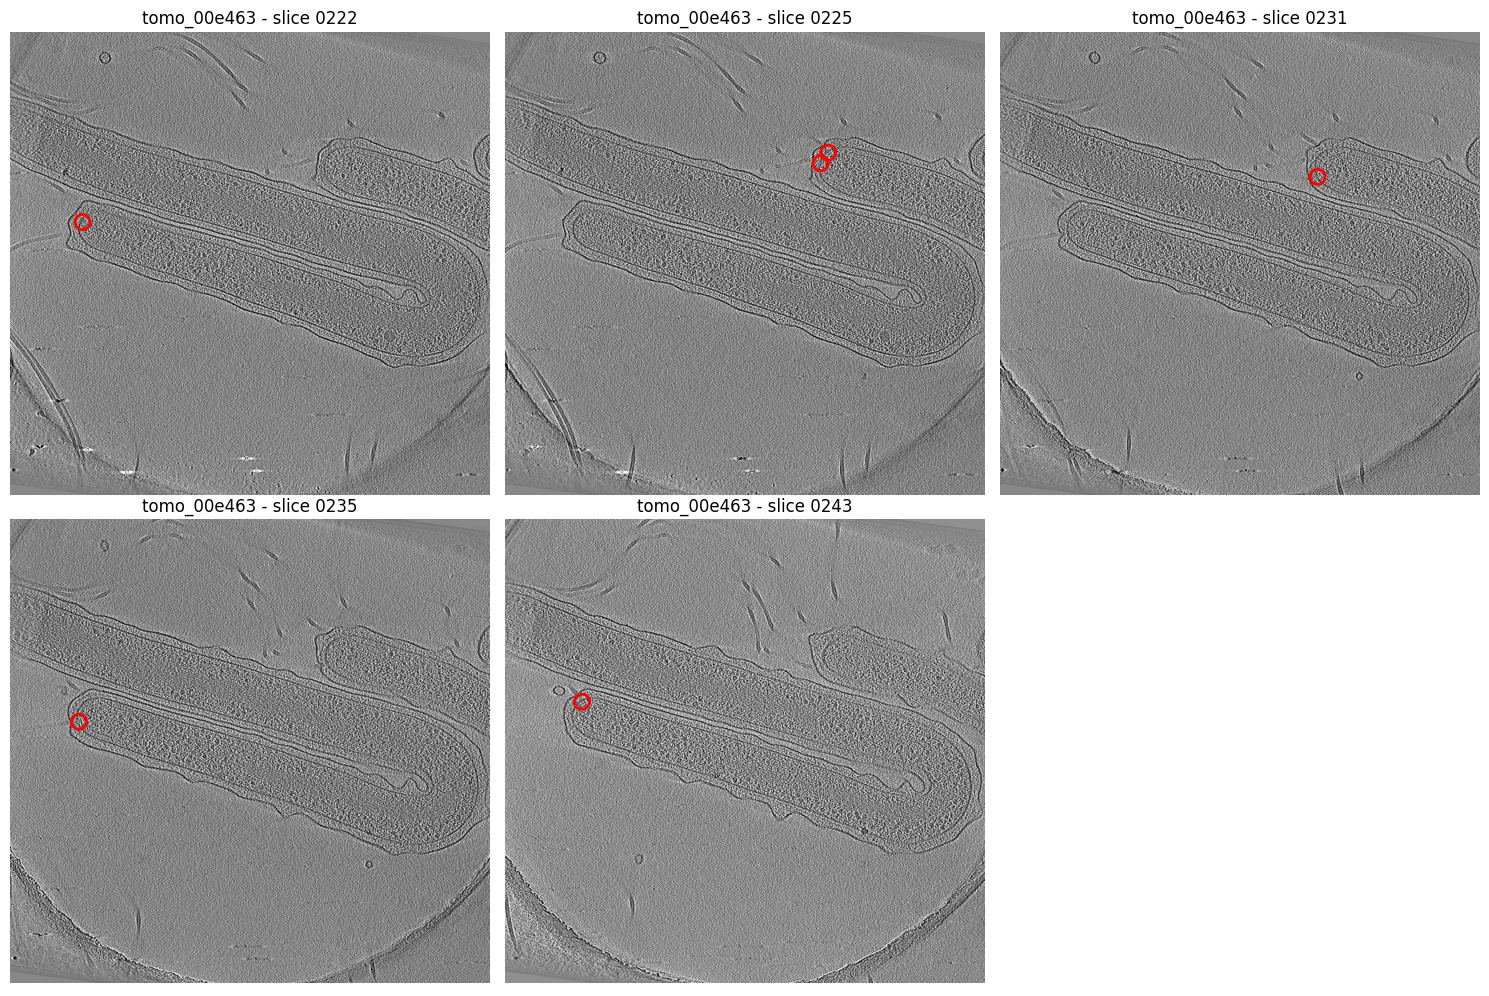

In [ ]:
import matplotlib.patches as patches # Import the patches module

def annotate_motors(tomo_folder_path, csv_path, radius=10, cols=3):
    """
    Annotates all motors in a single tomo folder, grouping motors per slice and
    displaying images with all motor locations marked, side by side.

    Parameters:
        tomo_folder_path (str): Path to folder with slice_XXXX.jpg images
        csv_path (str): Path to CSV file with motor locations
        radius (int): Radius of circle drawn around motors
        cols (int): Number of columns for side-by-side display
    """
    tomo_id = os.path.basename(os.path.normpath(tomo_folder_path))
    df = pd.read_csv(csv_path)
    df_valid = df[(df['tomo_id'] == tomo_id) & (df['Motor axis 0'] >= 0)]

    if df_valid.empty:
        print(f"No valid motor entries found for {tomo_id}")
        return

    # Group motors by slice index (axis 0)
    grouped = df_valid.groupby('Motor axis 0')

    num_slices = len(grouped)
    rows = math.ceil(num_slices / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axs = axs.flatten()  # for easy indexing

    for i, (z, group) in enumerate(grouped):
        z = int(z)
        image_name = f"slice_{z:04d}.jpg"
        image_path = os.path.join(tomo_folder_path, image_name)

        if not os.path.exists(image_path):
            print(f"Missing: {image_path}")
            continue

        img = mpimg.imread(image_path)
        ax = axs[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"{tomo_id} - slice {z:04d}")
        ax.axis('off')

        # Draw all motor positions in this slice
        for _, row in group.iterrows():
            x = row['Motor axis 2']
            y = row['Motor axis 1']
            circ = patches.Circle((x, y), radius=radius, edgecolor='red', facecolor='none', linewidth=2)
            ax.add_patch(circ)

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    plt.show()



tomo_folder_path = '/content/drive/MyDrive/BacterialFlagellarMotorsData/train/tomo_00e463'
csv_path = '/content/drive/MyDrive/BacterialFlagellarMotorsData/train_labels.csv'

annotate_motors(tomo_folder_path, csv_path, radius = 15)

In [ ]:
def plot_3d_volume(folder_path, level=0.6, opacity=0.02, downsample=2):
    """
    Load JPG slices from a folder and render them as a 3D volume using ipyvolume.

    Parameters:
        folder_path (str): Path to the folder containing .jpg slices
        level (float): Isosurface threshold (0 to 1)
        opacity (float): Opacity of the volume rendering
        downsample (int): Downsampling factor for memory efficiency
    """
    # Step 1: Get and sort all .jpg image paths
    image_paths = sorted([
        os.path.join(folder_path, f)
        for f in os.listdir(folder_path)
        if f.endswith('.jpg')
    ])

    print(f"Number of JPG slices found: {len(image_paths)}")

    # Step 2: Stack into volume
    volume = np.stack([mpimg.imread(p) for p in image_paths])
    print("Original volume shape:", volume.shape)

    # Step 3: Normalize to [0, 1]
    volume_norm = (volume - np.min(volume)) / (np.max(volume) - np.min(volume))

    # Step 4: Downsample for rendering
    if downsample > 1:
        volume_ds = volume_norm[::downsample, ::downsample, ::downsample]
    else:
        volume_ds = volume_norm

    print("Downsampled volume shape:", volume_ds.shape)

    # Step 5: Display 3D volume
    ipv.figure()
    ipv.volshow(volume_ds, level=level, opacity=opacity)
    ipv.show()

folder_path = '/content/drive/MyDrive/BacterialFlagellarMotorsData/test/tomo_003acc'
#plot_3d_volume(folder_path)
